In [24]:
import baselineUtils
import torch
import individual_TF
import scipy.io
from transformer.batch import subsequent_mask
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import operator
plt.rcParams["figure.figsize"] = (4,4)

In [5]:
test_data=pd.read_table(r'D:\Transformers\Trajectory Tracking Git Code\Trajectory-Transformer-master\datasets\merged_data\test\mix_test_locations.txt', delimiter = '\t')


In [6]:
test_data.columns = ['frame', 'person', 'x', 'y']


In [25]:
device=torch.device("cpu")

In [26]:
model=individual_TF.IndividualTF(2, 3, 3, N=6,
                   d_model=512, d_ff=2048, h=8, dropout=0.1,mean=[0,0],std=[0,0]).to(device)

In [27]:
PATH = f'models/Individual/merged_data_train_50/00049.pth'

In [28]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
test_dataset,_ =  baselineUtils.create_dataset('datasets','merged_data',0,8,12,
                                               '\t',train=False,eval=True,verbose='store_true')
train_dataset,_ =  baselineUtils.create_dataset('datasets','merged_data',0,8,12,
                                               '\t',train=True,eval=True,verbose='store_true')

start loading dataset
validation set size -> 0
001 / 001 - loading merge_test.txt
start loading dataset
validation set size -> 0
001 / 001 - loading merge_train.txt


In [30]:
test_dl = torch.utils.data.DataLoader(test_dataset, 20, shuffle=False, num_workers=0)
train_dl = torch.utils.data.DataLoader(train_dataset, 20, shuffle=False, num_workers=0)

In [36]:
model.eval()
gt = []
pr = []
inp_ = []
peds = []
frames = []
dt = []
norm = scipy.io.loadmat(f'models/Individual/merged_data_train_50/norm.mat')
mean = norm['mean']
std = norm['std']

In [37]:
for id_b,batch in enumerate(test_dl):
                    inp_.append(batch['src'])
                    gt.append(batch['trg'][:,:,0:2])
                    frames.append(batch['frames'])
                    peds.append(batch['peds'])
                    dt.append(batch['dataset'])

                    inp = (batch['src'][:, 1:, 2:4].to(device) - mean) / std
                    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
                    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(
                        device)
                    dec_inp=start_of_seq

                    for i in range(12):
                        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
                        out = model(inp, dec_inp, src_att, trg_att)
                        dec_inp=torch.cat((dec_inp,out[:,-1:,:]),1)


                    preds_tr_b=(dec_inp[:,1:,0:2].detach().numpy()*std+mean).cumsum(1)+batch['src'][:,-1:,0:2].cpu().numpy()
                    pr.append(preds_tr_b)
                    print("test epoch %03i/%03i  batch %04i / %04i" % (
                    20, 20, id_b, len(test_dl)))

test epoch 020/020  batch 0000 / 0102
test epoch 020/020  batch 0001 / 0102
test epoch 020/020  batch 0002 / 0102
test epoch 020/020  batch 0003 / 0102
test epoch 020/020  batch 0004 / 0102
test epoch 020/020  batch 0005 / 0102
test epoch 020/020  batch 0006 / 0102
test epoch 020/020  batch 0007 / 0102
test epoch 020/020  batch 0008 / 0102
test epoch 020/020  batch 0009 / 0102
test epoch 020/020  batch 0010 / 0102
test epoch 020/020  batch 0011 / 0102
test epoch 020/020  batch 0012 / 0102
test epoch 020/020  batch 0013 / 0102
test epoch 020/020  batch 0014 / 0102
test epoch 020/020  batch 0015 / 0102
test epoch 020/020  batch 0016 / 0102
test epoch 020/020  batch 0017 / 0102
test epoch 020/020  batch 0018 / 0102
test epoch 020/020  batch 0019 / 0102
test epoch 020/020  batch 0020 / 0102
test epoch 020/020  batch 0021 / 0102
test epoch 020/020  batch 0022 / 0102
test epoch 020/020  batch 0023 / 0102
test epoch 020/020  batch 0024 / 0102
test epoch 020/020  batch 0025 / 0102
test epoch 0

In [38]:
peds = np.concatenate(peds, 0)
frames = np.concatenate(frames, 0)
dt = np.concatenate(dt, 0)
gt = np.concatenate(gt, 0)
dt_names = test_dataset.data['dataset_name']
pr = np.concatenate(pr, 0)

In [11]:
gt[1]

array([[ 8.254233, 52.284664],
       [ 8.581543, 53.797318],
       [10.207323, 53.685192],
       [11.176221, 54.78788 ],
       [12.822845, 54.608997],
       [15.522993, 53.728462],
       [16.156412, 55.638405],
       [16.956007, 56.93661 ],
       [18.50484 , 55.676243],
       [19.78015 , 54.945168],
       [19.990683, 54.55509 ],
       [21.210093, 54.906666]], dtype=float32)

In [12]:
pr[1]

array([[ 9.442457 , 53.969723 ],
       [ 9.703604 , 53.936096 ],
       [ 9.9885435, 53.873787 ],
       [10.284642 , 53.831284 ],
       [10.589655 , 53.80496  ],
       [10.903215 , 53.78756  ],
       [11.223044 , 53.776028 ],
       [11.544752 , 53.7691   ],
       [11.864537 , 53.765385 ],
       [12.180593 , 53.762993 ],
       [12.4939995, 53.76046  ],
       [12.807815 , 53.758743 ]], dtype=float32)

In [13]:
locations = np.empty((10,10,2))
for i in range(10):
    for j in range(10):
        locations[i][j][0] = i*100
        locations[i][j][1] = j*100

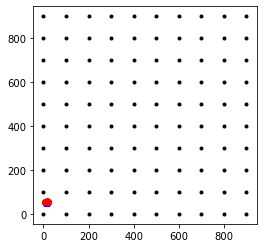

In [14]:
idx = 0
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red')
# plt.savefig("{}.png".format(idx))

In [15]:
pr[21]

array([[26.320381, 46.624954],
       [26.52286 , 46.583645],
       [26.725775, 46.52052 ],
       [26.936674, 46.49318 ],
       [27.15713 , 46.49065 ],
       [27.386982, 46.49909 ],
       [27.623283, 46.512   ],
       [27.861362, 46.528625],
       [28.097502, 46.549263],
       [28.330502, 46.573715],
       [28.562218, 46.603245],
       [28.796465, 46.64274 ]], dtype=float32)

In [16]:
gt[21]

array([[26.522408, 45.98692 ],
       [26.989923, 45.70591 ],
       [27.584888, 45.340694],
       [27.92454 , 45.088398],
       [28.159967, 45.169876],
       [28.331358, 45.251835],
       [28.714327, 45.08246 ],
       [29.288988, 44.856144],
       [29.692677, 44.603363],
       [29.947989, 44.490444],
       [30.09887 , 44.683556],
       [30.48121 , 44.43094 ]], dtype=float32)

In [17]:
frames

array([[6723, 6724, 6725, ..., 6740, 6741, 6742],
       [6724, 6725, 6726, ..., 6741, 6742, 6743],
       [6725, 6726, 6727, ..., 6742, 6743, 6744],
       ...,
       [9176, 9177, 9178, ..., 9193, 9194, 9195],
       [9177, 9178, 9179, ..., 9194, 9195, 9196],
       [9225, 9226, 9227, ..., 9242, 9243, 9244]], dtype=int64)

In [18]:
inp_[0].shape

torch.Size([20, 8, 4])

In [19]:
test_dataset.data['seq_start']

array([[[  7.591576 ,  57.839523 ]],

       [[ 11.384314 ,  51.234394 ]],

       [[  7.7719364,  59.114635 ]],

       ...,

       [[197.6974   ,   4.9196606]],

       [[199.35265  ,   9.107674 ]],

       [[550.       , 300.       ]]], dtype=float32)

In [20]:
peds

array([380., 380., 380., 380., 380., 380., 380., 380., 380., 380., 380.,
       380., 380., 380., 380., 380., 380., 380., 380., 380., 380., 380.,
       380., 380., 380., 380., 380., 380., 380., 380., 380., 380., 380.,
       380., 380., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 381., 381., 381., 381., 381., 381., 381., 381.,
       381., 381., 381., 382., 382., 382., 382., 385., 385., 385., 385.,
       385., 385., 385., 385., 385., 385., 385., 385., 388., 388., 388.,
       388., 388., 388., 388., 388., 388., 388., 388., 388., 388., 388.,
       388., 388., 388., 388., 388., 388., 388., 38

In [39]:
ssum = 0
for i in range(pr.shape[0]):
    ssum += math.dist(pr[i][-1], gt[i][-1])
mean_fde = ssum / (i+1)
print("The mean FDE is ",mean_fde)

The mean FDE is  317.91030286279084


In [40]:
ssum = 0
for i in range(pr.shape[0]):
    local_sum = 0
    for j in range(pr[i].shape[0]):
        local_sum += math.dist(pr[i][j], gt[i][j])
    ssum += local_sum / (j+1)
mean_ade = ssum / (i+1)
print("The mean ADE is ",mean_ade)

The mean ADE is  165.51942723239725


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


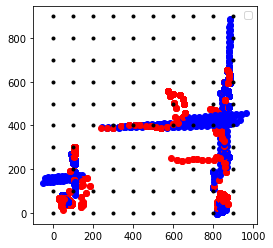

In [23]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
for i in range(80,200):
    plt.scatter(pr[i][:,0], pr[i][:,1], color='blue')
    plt.scatter(gt[i][:,0], gt[i][:,1], color='red')
plt.legend()
plt.show() 

In [31]:
model.eval()
gt = []
pr = []
inp_ = []
peds = []
frames = []
dt = []
norm = scipy.io.loadmat(f'models/Individual/merged_data_train_50/norm.mat')
mean = norm['mean']
std = norm['std']

In [32]:
for id_b,batch in enumerate(train_dl):
                    inp_.append(batch['src'])
                    gt.append(batch['trg'][:,:,0:2])
                    frames.append(batch['frames'])
                    peds.append(batch['peds'])
                    dt.append(batch['dataset'])

                    inp = (batch['src'][:, 1:, 2:4].to(device) - mean) / std
                    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
                    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(
                        device)
                    dec_inp=start_of_seq

                    for i in range(12):
                        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
                        out = model(inp, dec_inp, src_att, trg_att)
                        dec_inp=torch.cat((dec_inp,out[:,-1:,:]),1)


                    preds_tr_b=(dec_inp[:,1:,0:2].detach().numpy()*std+mean).cumsum(1)+batch['src'][:,-1:,0:2].cpu().numpy()
                    pr.append(preds_tr_b)
                    print("test epoch %03i/%03i  batch %04i / %04i" % (
                    20, 20, id_b, len(test_dl)))

test epoch 020/020  batch 0000 / 0102
test epoch 020/020  batch 0001 / 0102
test epoch 020/020  batch 0002 / 0102
test epoch 020/020  batch 0003 / 0102
test epoch 020/020  batch 0004 / 0102
test epoch 020/020  batch 0005 / 0102
test epoch 020/020  batch 0006 / 0102
test epoch 020/020  batch 0007 / 0102
test epoch 020/020  batch 0008 / 0102
test epoch 020/020  batch 0009 / 0102
test epoch 020/020  batch 0010 / 0102
test epoch 020/020  batch 0011 / 0102
test epoch 020/020  batch 0012 / 0102
test epoch 020/020  batch 0013 / 0102
test epoch 020/020  batch 0014 / 0102
test epoch 020/020  batch 0015 / 0102
test epoch 020/020  batch 0016 / 0102
test epoch 020/020  batch 0017 / 0102
test epoch 020/020  batch 0018 / 0102
test epoch 020/020  batch 0019 / 0102
test epoch 020/020  batch 0020 / 0102
test epoch 020/020  batch 0021 / 0102
test epoch 020/020  batch 0022 / 0102
test epoch 020/020  batch 0023 / 0102
test epoch 020/020  batch 0024 / 0102
test epoch 020/020  batch 0025 / 0102
test epoch 0

test epoch 020/020  batch 0216 / 0102
test epoch 020/020  batch 0217 / 0102
test epoch 020/020  batch 0218 / 0102
test epoch 020/020  batch 0219 / 0102
test epoch 020/020  batch 0220 / 0102
test epoch 020/020  batch 0221 / 0102
test epoch 020/020  batch 0222 / 0102
test epoch 020/020  batch 0223 / 0102
test epoch 020/020  batch 0224 / 0102
test epoch 020/020  batch 0225 / 0102
test epoch 020/020  batch 0226 / 0102
test epoch 020/020  batch 0227 / 0102
test epoch 020/020  batch 0228 / 0102
test epoch 020/020  batch 0229 / 0102
test epoch 020/020  batch 0230 / 0102
test epoch 020/020  batch 0231 / 0102
test epoch 020/020  batch 0232 / 0102
test epoch 020/020  batch 0233 / 0102
test epoch 020/020  batch 0234 / 0102
test epoch 020/020  batch 0235 / 0102
test epoch 020/020  batch 0236 / 0102
test epoch 020/020  batch 0237 / 0102
test epoch 020/020  batch 0238 / 0102
test epoch 020/020  batch 0239 / 0102
test epoch 020/020  batch 0240 / 0102
test epoch 020/020  batch 0241 / 0102
test epoch 0

test epoch 020/020  batch 0432 / 0102
test epoch 020/020  batch 0433 / 0102
test epoch 020/020  batch 0434 / 0102
test epoch 020/020  batch 0435 / 0102
test epoch 020/020  batch 0436 / 0102
test epoch 020/020  batch 0437 / 0102
test epoch 020/020  batch 0438 / 0102
test epoch 020/020  batch 0439 / 0102
test epoch 020/020  batch 0440 / 0102
test epoch 020/020  batch 0441 / 0102
test epoch 020/020  batch 0442 / 0102
test epoch 020/020  batch 0443 / 0102
test epoch 020/020  batch 0444 / 0102
test epoch 020/020  batch 0445 / 0102
test epoch 020/020  batch 0446 / 0102
test epoch 020/020  batch 0447 / 0102
test epoch 020/020  batch 0448 / 0102
test epoch 020/020  batch 0449 / 0102
test epoch 020/020  batch 0450 / 0102
test epoch 020/020  batch 0451 / 0102
test epoch 020/020  batch 0452 / 0102
test epoch 020/020  batch 0453 / 0102
test epoch 020/020  batch 0454 / 0102
test epoch 020/020  batch 0455 / 0102
test epoch 020/020  batch 0456 / 0102
test epoch 020/020  batch 0457 / 0102
test epoch 0

test epoch 020/020  batch 0648 / 0102
test epoch 020/020  batch 0649 / 0102
test epoch 020/020  batch 0650 / 0102
test epoch 020/020  batch 0651 / 0102
test epoch 020/020  batch 0652 / 0102
test epoch 020/020  batch 0653 / 0102
test epoch 020/020  batch 0654 / 0102
test epoch 020/020  batch 0655 / 0102
test epoch 020/020  batch 0656 / 0102
test epoch 020/020  batch 0657 / 0102
test epoch 020/020  batch 0658 / 0102
test epoch 020/020  batch 0659 / 0102
test epoch 020/020  batch 0660 / 0102
test epoch 020/020  batch 0661 / 0102
test epoch 020/020  batch 0662 / 0102
test epoch 020/020  batch 0663 / 0102
test epoch 020/020  batch 0664 / 0102
test epoch 020/020  batch 0665 / 0102
test epoch 020/020  batch 0666 / 0102
test epoch 020/020  batch 0667 / 0102
test epoch 020/020  batch 0668 / 0102
test epoch 020/020  batch 0669 / 0102
test epoch 020/020  batch 0670 / 0102
test epoch 020/020  batch 0671 / 0102
test epoch 020/020  batch 0672 / 0102
test epoch 020/020  batch 0673 / 0102
test epoch 0

In [33]:
peds = np.concatenate(peds, 0)
frames = np.concatenate(frames, 0)
dt = np.concatenate(dt, 0)
gt = np.concatenate(gt, 0)
dt_names = test_dataset.data['dataset_name']
pr = np.concatenate(pr, 0)

In [34]:
ssum = 0
for i in range(pr.shape[0]):
    ssum += math.dist(pr[i][-1], gt[i][-1])
mean_fde = ssum / (i+1)
print("The mean FDE is ",mean_fde)

The mean FDE is  141.35947344130105


In [35]:
ssum = 0
for i in range(pr.shape[0]):
    local_sum = 0
    for j in range(pr[i].shape[0]):
        local_sum += math.dist(pr[i][j], gt[i][j])
    ssum += local_sum / (j+1)
mean_ade = ssum / (i+1)
print("The mean ADE is ",mean_ade)

The mean ADE is  77.68529818770193


# Lana's Merged Data

## Test Sample 1 - Using Polynomial Regression for trajectory correction
### Trajectory prediction using transformers
### Trajectory correction using polynomial regression

In [56]:
pedestrian_id = 161
idx = np.where(peds == pedestrian_id)[0][0]
frame_start = frames[idx]
full_sample = test_data[test_data['person'].isin([pedestrian_id])]
test_sample = test_data[test_data['frame'].isin(frame_start) & test_data['person'].isin([pedestrian_id])]
frame_idx = test_sample['frame'].iloc[0]
full_sample = full_sample[full_sample['frame'] >= frame_idx]

In [57]:
full_sample.iloc[19]

frame     1613.000000
person     161.000000
x          743.393642
y          329.060740
Name: 1611, dtype: float64

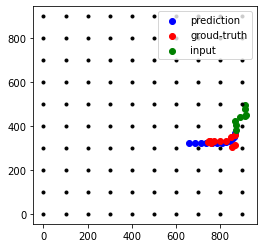

In [58]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')
plt.scatter(test_sample['x'][:8], test_sample['y'][:8], color='green', label ='input')
plt.legend()
plt.show()

In [307]:
loc_21timestep = full_sample.iloc[20][['x', 'y']].to_numpy()
x = np.append(test_sample['x'][:8], loc_21timestep[0])
y = np.append(test_sample['y'][:8], loc_21timestep[1])
# x = x[:, np.newaxis]
# y = y[:, np.newaxis]

In [308]:
myline = np.linspace(int(min(x) - 20), int(max(x) + 20), 20)
mymodel = np.poly1d(np.polyfit(x, y, 2))

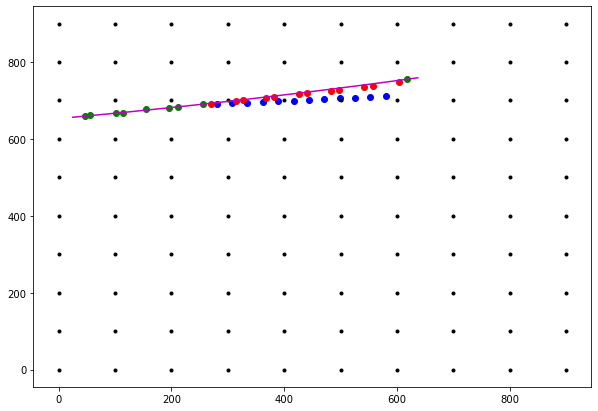

In [309]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(x, y, color='green')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')
plt.plot(myline, mymodel(myline), color='m')
plt.show()

In [310]:
predicted_line = [[i, j] for i, j in zip(myline, mymodel(myline))]

In [311]:
predicted_line

[[25.0, 656.2900640174731],
 [57.21052631578947, 660.7025798203094],
 [89.42105263157895, 665.2249477043546],
 [121.63157894736841, 669.8571676696085],
 [153.8421052631579, 674.5992397160712],
 [186.05263157894737, 679.4511638437427],
 [218.26315789473682, 684.4129400526231],
 [250.4736842105263, 689.4845683427122],
 [282.6842105263158, 694.6660487140101],
 [314.89473684210526, 699.9573811665168],
 [347.10526315789474, 705.3585657002324],
 [379.3157894736842, 710.8696023151566],
 [411.52631578947364, 716.4904910112897],
 [443.7368421052631, 722.2212317886316],
 [475.9473684210526, 728.0618246471823],
 [508.1578947368421, 734.0122695869418],
 [540.3684210526316, 740.0725666079101],
 [572.578947368421, 746.2427157100872],
 [604.7894736842105, 752.522716893473],
 [637.0, 758.9125701580676]]

In [312]:
shifted_path = np.copy(pr[idx])
# for i in range(pr[idx].shape[0]):
#     short_x = 0
#     short_y = 0
#     shortest_distance = 1000
#     for j in range(len(predicted_line)):
#         if shortest_distance > math.dist(pr[idx][i], predicted_line[j]):
#             shortest_distance = math.dist(pr[idx][i], predicted_line[j])
#             short_x = predicted_line[j][0]
#             short_y = predicted_line[j][1]
#     print("Short distance: ", shortest_distance)
#     print("Short x: ", short_x)
#     print("Short y: ", short_y)
#     shifted_path[i] = np.array([abs(short_x+pr[idx][i][0])/2, abs(short_y+pr[idx][i][1])/2]).reshape(2)
for i in range(2):
        for j in range(8,20):
            shifted_path[j-8] = np.array([(shifted_path[j-8][0] + predicted_line[j][0])/2, (shifted_path[j-8][1] + predicted_line[j][1])/2])

In [313]:
# shifted_path = np.array([[i, j] for i, j in zip(pr[idx][:,0].reshape(12,1), model.predict(polynomial_features.fit_transform(pr[idx][:,0].reshape(12, 1))))])

In [314]:
shifted_path

array([[282.25345, 693.8918 ],
       [313.00323, 698.16016],
       [343.96613, 702.59064],
       [374.9898 , 707.1585 ],
       [406.0117 , 711.8331 ],
       [437.01688, 716.599  ],
       [468.0057 , 721.45184],
       [498.98154, 726.38965],
       [529.9472 , 731.4081 ],
       [560.9046 , 736.502  ],
       [591.8547 , 741.66864],
       [622.7982 , 746.91003]], dtype=float32)

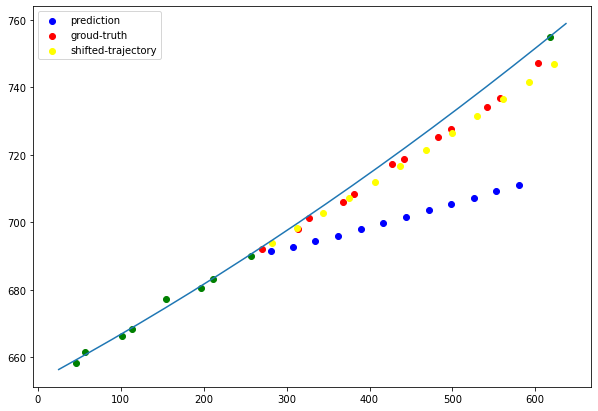

In [315]:
#plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(x, y, color='green')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')
plt.scatter(shifted_path[:,0], shifted_path[:,1], color='yellow', label ='shifted-trajectory')
plt.plot(myline, mymodel(myline))
plt.legend()
plt.show()

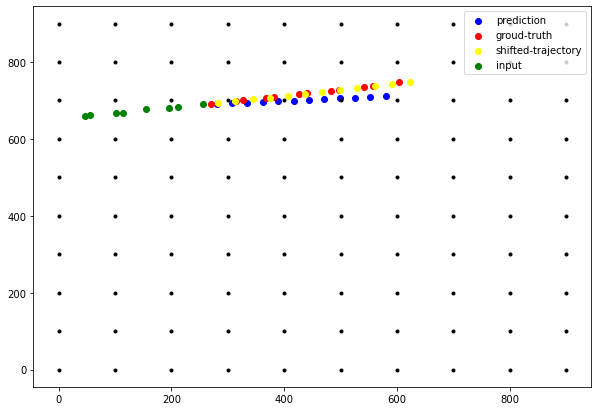

In [316]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')
plt.scatter(shifted_path[:,0], shifted_path[:,1], color='yellow', label ='shifted-trajectory')
plt.scatter(test_sample['x'][:8], test_sample['y'][:8], color='green', label ='input')
plt.legend()
plt.show()

## Test for 4 past and 4 future

In [67]:
det_49 = scipy.io.loadmat(f'output/Individual/merged_data_train_4x4/det_49.mat')

In [86]:
gt = det_49['gt']
pr = det_49['pr']
peds = det_49['peds']
frames = det_49['frames']

In [69]:
gt[0]


array([[ 66.31596 , 320.05048 ],
       [ 71.04121 , 330.0676  ],
       [ 75.358475, 370.472   ],
       [ 74.61401 , 377.07358 ]], dtype=float32)

In [70]:
pr[0]

array([[ 68.661606, 281.23428 ],
       [ 67.784676, 282.22144 ],
       [ 67.23668 , 282.20822 ],
       [ 66.84748 , 281.9455  ]], dtype=float32)

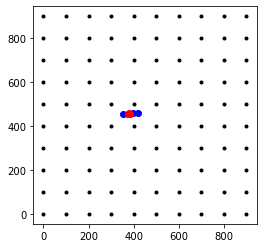

In [72]:
    idx = 2
    plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
    plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
    plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


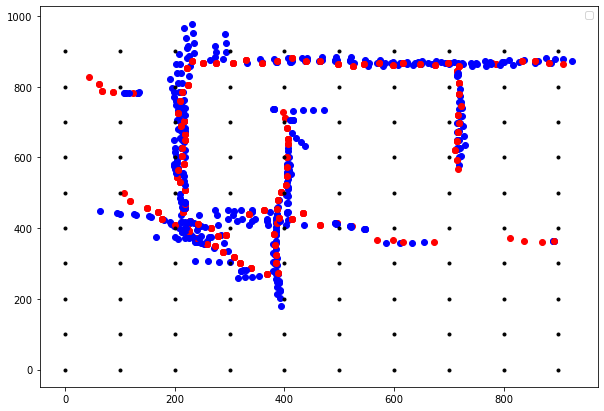

In [33]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
for i in range(600,700):
    plt.scatter(pr[i][:,0], pr[i][:,1], color='blue')
    plt.scatter(gt[i][:,0], gt[i][:,1], color='red')
plt.legend()
plt.show()   

In [34]:
ssum = 0
for i in range(pr.shape[0]):
    ssum += math.dist(pr[i][-1], gt[i][-1])
mean_fde = ssum / (i+1)
print("The mean FDE is ",mean_fde)

The mean FDE is  57.82056008631463


In [35]:
ssum = 0
for i in range(pr.shape[0]):
    local_sum = 0
    for j in range(pr[i].shape[0]):
        local_sum += math.dist(pr[i][j], gt[i][j])
    ssum += local_sum / (j+1)
mean_ade = ssum / (i+1)
print("The mean ADE is ",mean_ade)

The mean ADE is  36.54902937743179


In [172]:
pedestrian_id = 172
idx = np.where(peds == pedestrian_id)[1][0]
frame_start = frames[idx]
full_sample = test_data[test_data['person'].isin([pedestrian_id])]
test_sample = test_data[test_data['frame'].isin(frame_start) & test_data['person'].isin([pedestrian_id])]
frame_idx = test_sample['frame'].iloc[0]
full_sample = full_sample[full_sample['frame'] >= frame_idx]

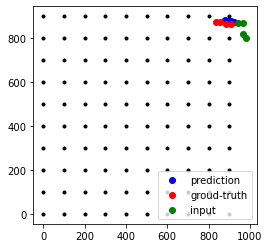

In [173]:
plt.plot(locations[:,:,0], locations[:,:,1], ls="None", marker=".",color='black')
plt.scatter(pr[idx][:,0], pr[idx][:,1], color='blue', label ='prediction')
plt.scatter(gt[idx][:,0], gt[idx][:,1], color='red', label ='groud-truth')
plt.scatter(test_sample['x'][:4], test_sample['y'][:4], color='green', label ='input')
plt.legend()
plt.show()

In [131]:
peds

array([[  2.,   3.,   3.,   3.,   6.,   6.,   6.,   6.,   9.,   9.,   9.,
          9.,   9.,   9.,   9.,   9.,  12.,  14.,  14.,  15.,  15.,  15.,
         15.,  15.,  19.,  19.,  19.,  20.,  22.,  22.,  24.,  25.,  25.,
         25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  26.,
         26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,
         26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,
         26.,  26.,  26.,  26.,  26.,  26.,  26.,  27.,  28.,  28.,  28.,
         29.,  29.,  29.,  29.,  29.,  29.,  30.,  30.,  30.,  31.,  31.,
         31.,  31.,  33.,  33.,  33.,  33.,  33.,  33.,  33.,  33.,  36.,
         36.,  36.,  37.,  38.,  38.,  39.,  39.,  39.,  39.,  39.,  39.,
         39.,  39.,  39.,  39.,  39.,  39.,  39.,  40.,  40.,  40.,  40.,
         42.,  42.,  42.,  42.,  42.,  42.,  43.,  44.,  46.,  47.,  48.,
         48.,  48.,  50.,  50.,  52.,  52.,  52.,  52.,  52.,  55.,  55.,
         57.,  60.,  60.,  60.,  60., 